In [1]:
import numpy as np

# 5장 몬테카를로법

## 1. 몬테카를로법 기초

### 주사위 눈의 합

In [2]:
ps = {2 : 1/36, 3 : 2/36, 4 : 3/36, 5 : 4/36, 6 : 5/36, 7 : 6/36, 8 : 5/36, 9 : 4/36, 10 : 3/36, 11 : 2/36, 12 : 1/36}

V = 0

for x, p in ps.items() :
    V += x * p
    
print(V)

6.999999999999999


### 분포 모델과 샘플 모델

In [3]:
def sample(dices=2) :
    x = 0
    for _ in range(dices) :
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x

### 몬테카를로법 구현 : 샘플링 1000번 -> 평균

In [4]:
trial = 1000
samples = []

for _ in range(trial) :
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples)

print(V)

7.073


### 몬테카를로법 구현 : 샘플 데이터 얻을때마다 평균

In [ ]:
trial = 1000
samples = []

for _ in range(trial) :
    s = sample()
    samples.append(s)
    V = sum(samples) / len(samples)
    
    print(V)

### 몬테카를로법 구현 : 증분 적용

In [ ]:
trial = 1000
V, n = 0, 0

for _ in range(trial) :
    s = sample()
    n += 1
    V += (s - V) / n
    print(V)

## 3. 몬테카를로법 구현

### 몬테카를로법 구현 (gridWorld)

In [12]:
from chap5 import GridWorld, Renderer

env = GridWorld()
action = 0
next_state, reward, done = env.step(action)

print('next_state : ', next_state)
print('reward : ', reward)
print('done : ', done)

next_state :  (1, 0)
reward :  0
done :  False


### 에이전트 클래스 구현

In [14]:
from collections import defaultdict

class RandomAgent :
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.V = defaultdict(lambda : 0)
        self.cnts = defaultdict(lambda : 0)
        self.memory = []
        
    def get_action(self, state) :
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward) :
        data = (state, action, reward)
        
        self.memory.append(data)
        
    def reset(self) :
        self.memory.clear()
        
    def eval(self) :
        G = 0
        
        for data in reversed(self.memory) : # 역방향
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

### 몬테카를로법 실행

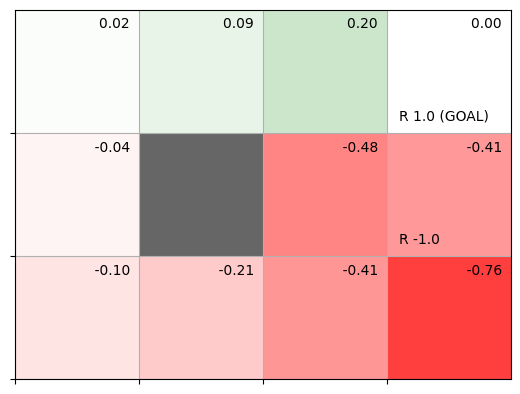

In [16]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes) :
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.add(state, action, reward)
        
        if (done) :
            agent.eval()
            break
        
        state = next_state
        
env.render_v(agent.V)

## 4. 몬테카를로법 -> 정책 제어

### 몬테카를로법 -> 정책반복법 (정책 제어)

In [20]:
class McAgent :
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1      # 앱실론-그리디
        self.alpha = 0.1        # Q함수 갱신 시 alpha
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0)
        self.cnts = defaultdict(lambda : 0)
        self.memory = []
        
    def get_action(self, state) :
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward) :
        data = (state, action, reward)
        
        self.memory.append(data)
        
    def reset(self) :
        self.memory.clear()
        
    def update(self) :
        G = 0
        for data in reversed(self.memory) :
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            # self.Q[key] += (G - self.Q[key]) / self.cnts[key] # 증분
            self.Q[key] += (G - self.Q[key]) * self.alpha       # 고정값 Alpha 방식
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)
            
def greedy_probs(Q, state, epsilon=0, action_size=4) :
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    
    base_prob = epsilon / action_size
    action_probs = {action : base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)       # Epsilon-Greedy Policy -> Q값 max 핻옹에 1-e 값 더함
    
    # action_probs = {action : 0.0 for action in range(action_size)}
    # action_probs[max_action] = 1        # Greedy Policy
    
    return action_probs

### 몬테카를로법 -> 정책반복법 구현 실행

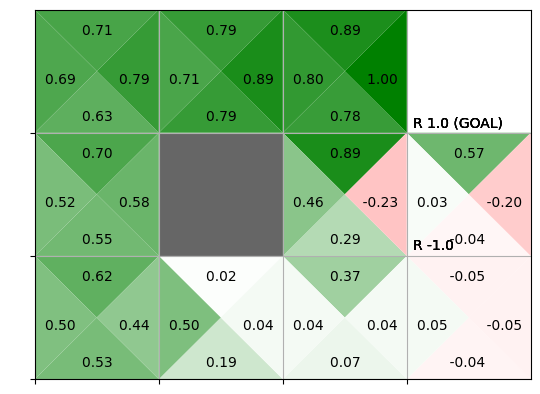

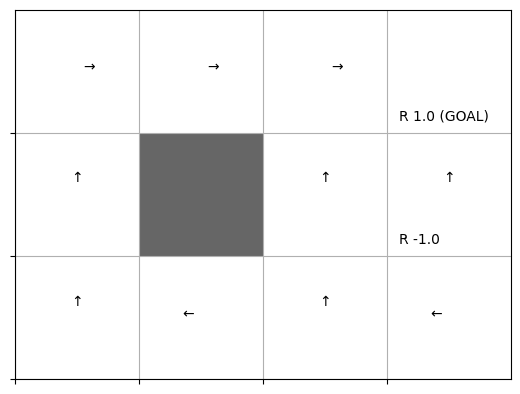

In [23]:
env = GridWorld()
agent = McAgent()

episodes = 10000

for episode in range(episodes) :
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.add(state, action, reward)
        
        if (done) :
            agent.update()
            break
        
        state = next_state
        
env.render_q(agent.Q)

## 5. 오프-정책 / 중요도 샘플링

### 중요도 샘플링

In [ ]:
import numpy as np

x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

e = np.sum(x * pi)
print("참값 (E_pi[x]) : ", e)

# 몬테카를로법으로 계산
n = 100
samples = []

for _ in range(n) :
    s = np.random.choice(x, p=pi)
    samples.append(s)
    
mean = np.mean(samples)     # 샘플 평균
var = np.var(samples)       # 샘플 분산

print("몬테카를로법 : {:.2f} (분산 : {:.2f})".format(mean, var))

참값 (E_pi[x]) :  2.7
몬테카를로법 : 2.71 (분산 : 0.41)


### 중요도 샘플링

In [28]:
import numpy as np

x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# 중요도 샘플링으로 계산
b = np.array([1/3, 1/3, 1/3])       # 확률 분포
n = 100
samples = []

for _ in range(n) :
    idx = np.arange(len(b))
    i = np.random.choice(idx, p=b)      # b 사용한 샘플링
    s = x[i]
    rho = pi[i] / b[i]      # 가중치
    samples.append(rho * s)
    
mean = np.mean(samples)     # 샘플 평균
var = np.var(samples)       # 샘플 분산

print("몬테카를로법 : {:.2f} (분산 : {:.2f})".format(mean, var))

몬테카를로법 : 2.63 (분산 : 9.86)


### 중요도 샘플링 - 분산 줄이기

In [29]:
import numpy as np

x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# 중요도 샘플링으로 계산
b = np.array([0.2, 0.2, 0.6]) # b = np.array([1/3, 1/3, 1/3])       # 확률 분포
n = 100
samples = []

for _ in range(n) :
    idx = np.arange(len(b))
    i = np.random.choice(idx, p=b)      # b 사용한 샘플링
    s = x[i]
    rho = pi[i] / b[i]      # 가중치
    samples.append(rho * s)
    
mean = np.mean(samples)     # 샘플 평균
var = np.var(samples)       # 샘플 분산

print("몬테카를로법 : {:.2f} (분산 : {:.2f})".format(mean, var))

몬테카를로법 : 2.63 (분산 : 2.60)


# 6장 TD법

## 1. TD법으로 정책 평가

### TD법 구현

In [30]:
from collections import defaultdict

class TdAgent :
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.V = defaultdict(lambda : 0)
        
    def get_action(self, state) :
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)
    
    def eval(self, state, reward, next_state, done) :
        next_V = 0 if done else self.V[next_state]
        target = reward + self.gamma * next_V
        self.V[state] += (target - self.V[state]) * self.alpha

### TD법 실행

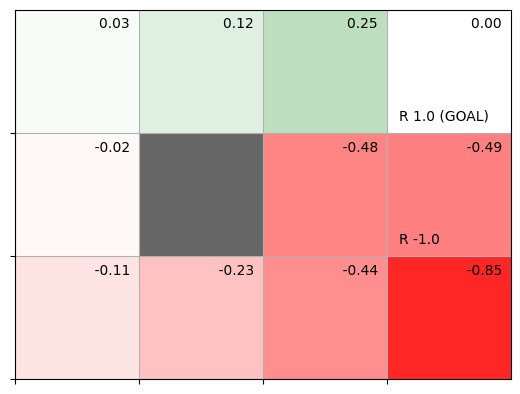

In [32]:
from chap5 import GridWorld

env = GridWorld()
agent = TdAgent()

episodes = 1000

for episode in range(episodes) :
    state = env.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.eval(state, reward, next_state, done)
        
        if (done) :
            break
        
        state = next_state

env.render_v(agent.V)

## 2. SARSA

### 온-정책 SARSA 구현

In [37]:
def greedy_probs(Q, state, epsilon=0, action_size=4) :
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    
    base_prob = epsilon / action_size
    action_probs = {action : base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)       # Epsilon-Greedy Policy -> Q값 max 핻옹에 1-e 값 더함
    
    # action_probs = {action : 0.0 for action in range(action_size)}
    # action_probs[max_action] = 1        # Greedy Policy
    
    return action_probs

from collections import deque

class SarsaAgent :
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0)
        self.memory = deque(maxlen=2)       # deque 사용
        
    def get_action(self, state) :
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)
    
    def reset(self) :
        self.memory.clear()
    
    def update(self, state, action, reward, done) :
        self.memory.append((state, action, reward, done))
        if (len(self.memory) < 2) :
            return
        
        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        
        next_q = 0 if done else self.Q[next_state, next_action]     # 다음 Q함수
        
        # TD법으로 self.Q 갱신
        target = reward + self.gamma * next_q
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        
        # 정책 개선
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

### 온-정책 SARSA 실행

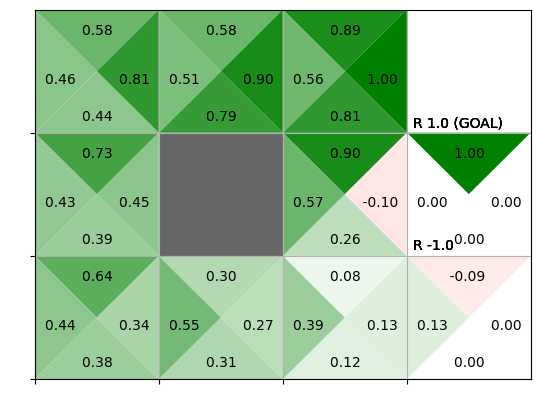

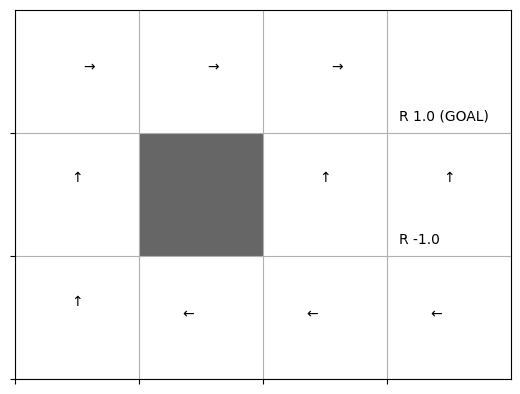

In [44]:
env = GridWorld()
agent = SarsaAgent()

episodes = 10000
for episode in range(episodes) :
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, done)       # 매번 호출
        
        if (done) :
            agent.update(next_state, None, None, None)
            break
        
        state = next_state
        
env.render_q(agent.Q)

## 3. 오프-정책 SARSA

### 오프-정책 SARSA 구현

In [45]:
class SarsaOffPolicyAgent :
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.b = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0)
        self.memory = deque(maxlen=2)       # deque 사용
        
    def get_action(self, state) :
        action_probs = self.b[state]        # 행동 정책 b에서 가져옴
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)
    
    def reset(self) :
        self.memory.clear()
    
    def update(self, state, action, reward, done) :
        self.memory.append((state, action, reward, done))
        if (len(self.memory) < 2) :
            return
        
        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        
        if (done) :
            next_q = 0
            rho = 1
        else :
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]        # 가중치 rho 계산
        
        # TD법으로 self.Q 갱신
        target = rho * (reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        
        # 각각 정책 개선
        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

### 오프-정책 SARSA 실행

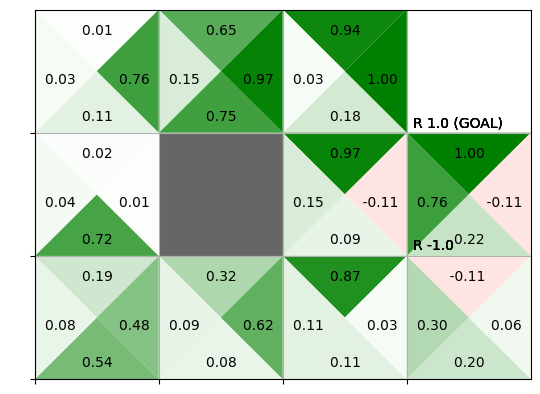

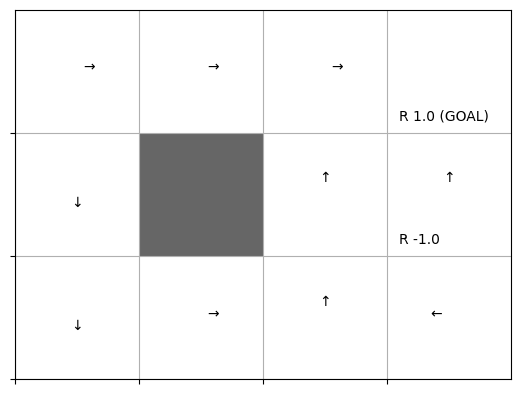

In [46]:
env = GridWorld()
agent = SarsaOffPolicyAgent()

episodes = 10000
for episode in range(episodes) :
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, done)       # 매번 호출
        
        if (done) :
            agent.update(next_state, None, None, None)
            break
        
        state = next_state
        
env.render_q(agent.Q)

## 4. Q-러닝

### Q-러닝 구현

In [133]:
class QLearningAgent :
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        # self.pi = defaultdict(lambda : random_actions)
        self.b = defaultdict(lambda : random_actions)       #행동 정책
        self.Q = defaultdict(lambda : 0)
        
    def get_action(self, state) :
        action_probs = self.b[state]        # 행동 정책 b에서 가져옴
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)
    
    def update(self, state, action, reward, next_state, done) :
        if (done) :
            next_q_max = 0
        else : 
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)
            
        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

### Q-러닝 실행

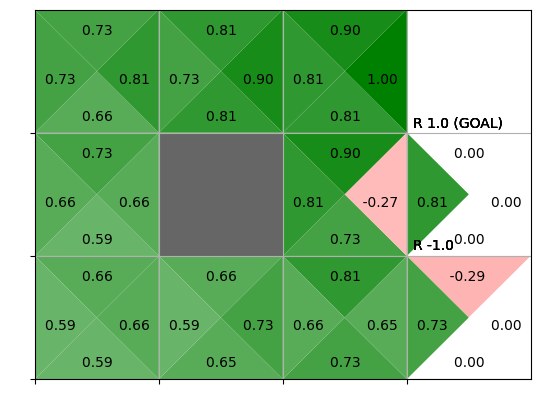

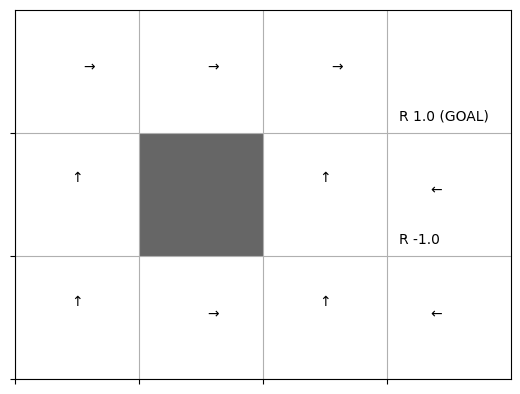

In [135]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes) :
    state = env.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, next_state, done)       # 매번 호출
        
        if (done) :
            break
        
        state = next_state
        
env.render_q(agent.Q)

## Dezero 기초

### Dezero 사용법

In [ ]:
from dezero import Variable

x_np = np.array(5.0)
x = Variable(x_np)

y = 3 * x ** 2
print(y, type(y))

y.backward()        # 역전파 -> 변수 미분 계산
print(x.grad)       # y = 3x^2 -> y' = 6x, x = 5 --> y' = 30

variable(75.0) <class 'dezero.core.Variable'>
variable(30.0)


### 다차원 배열 (텐서)과 함수

In [55]:
import numpy as np
from dezero import Variable
import dezero.functions as F

# 벡터 내적
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

a, b = Variable(a), Variable(b)

c = F.matmul(a, b)

print(c)

# 행렬곱
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = F.matmul(a, b)

print(c)

variable(32)
variable([[19 22]
          [43 50]])


### 최적화 - 로젠브록 함수

In [56]:
def rosenbrock(x0, x1) :
    """ rosenbrock function """
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()

print(x0.grad, x1.grad)

variable(-2.0) variable(400.0)


### 최적화 - 경사 하강법

In [57]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

iters = 10000       # 반복 횟수
lr = 0.001          # 학습률 (learning rate)

for i in range(iters) :
    y = rosenbrock(x0, x1)
    
    x0.cleargrad()
    x1.cleargrad()
    
    y.backward()        # 미분 (역전파)
    
    # 변수 갱신
    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data
    
print(x0, x1)

variable(0.9944984367782456) variable(0.9890050527419593)


## 2. 선형회귀

### 토이 데이터셋

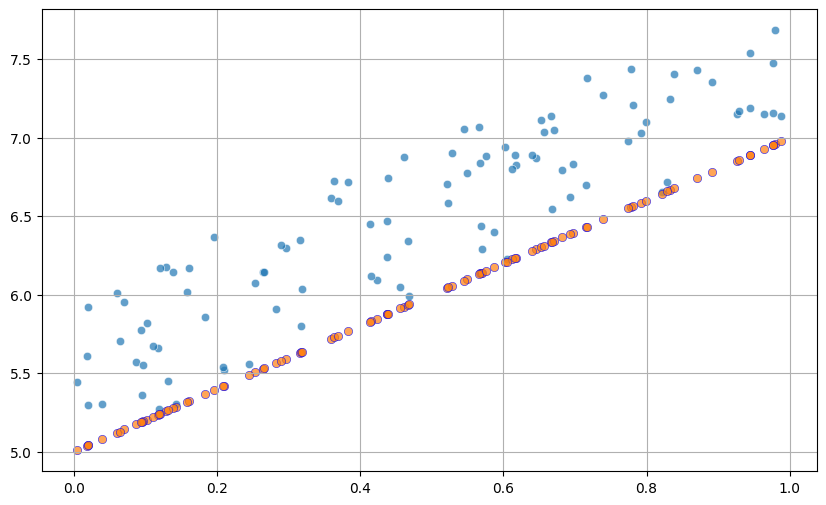

In [66]:
import matplotlib.pyplot as plt

np.random.seed(0)

x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1) # y = 2x + 5 + noise 형태 
y0 = 5 + 2 * x

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, edgecolors='w', linewidths=0.5)
plt.scatter(x, y0, alpha=0.7, edgecolors='b', linewidths=0.5)

plt.grid(True)
plt.show()

### 선형 회귀 구현

42.296340129442335
0.10078974954301652
0.0902667138137311
0.08441084206493275
0.08099850454041051
W = [[2.11807369]]
b = [5.46608905]


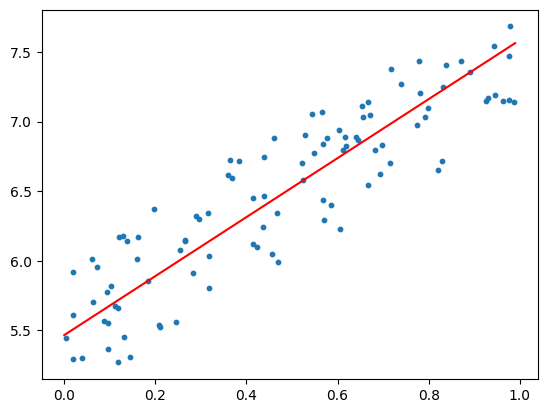

In [67]:
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))      # Weight : 가중치
b = Variable(np.zeros(1))           # Bias : 편향

# 예측 함수
def predict(x) :
    y = F.matmul(x, W) + b
    return y

def mean_squared_error(x0, x1) :
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters) :
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)
    
    W.cleargrad()
    b.cleargrad()
    
    loss.backward()
    
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    
    if (i % 20 == 0) :
        print(loss.data)
        
print(f"W = {W.data}")
print(f"b = {b.data}")

plt.scatter(x.data, y.data, s=10)
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)

plt.plot(t, y_pred.data, color='r')
plt.show()

## 3. 신경망

### 비선형 데이터셋

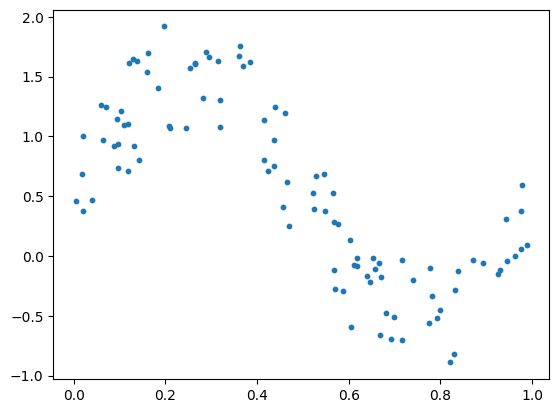

In [68]:
import numpy as np

np.random.seed(0)

x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)      # 2x * pi + noise

plt.scatter(x, y, s=10)
plt.show()

### 신경망 구현

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

np.random.seed(0)

x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)      # 2x * pi + noise

I, H, O = 1, 10, 1      # I : 입력층 차원 수, H : 은닉층 차원 수, O : 출력층 차원 수

W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

def predict(x) :
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    
    return y

lr = 0.2
iters = 10000

for i in range(iters) :
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    
    loss.backward()
    
    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    
    if (i % 2000 == 0) :
        print(loss.data)
        
# 신경망 구현
# x (100 * 1) * W1 (1 * 10) -> xW1 (100 * 10) * W2 (10 * 1) -> xW1W2 (100 * 1)

0.8473695850105871
0.2475948546674987
0.21222231333102926
0.09681932619992642
0.07749729552991151


### 신경망 구현 - 2

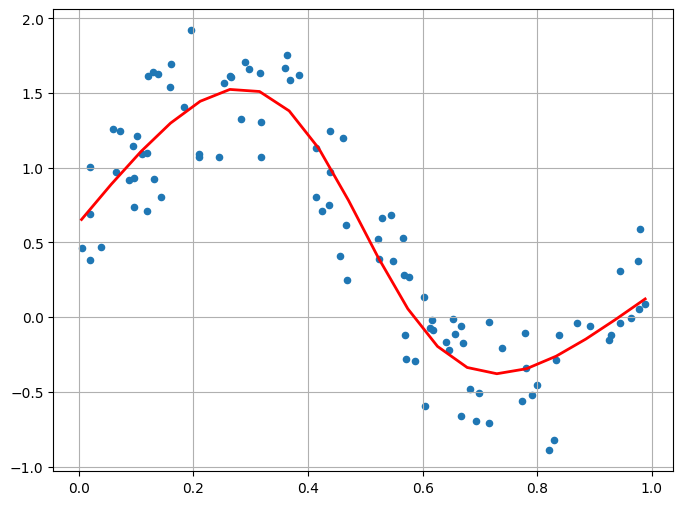

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from dezero import Variable
import dezero.functions as F

x_min = np.min(x)
x_max = np.max(x)
interval = 20
x_test = np.linspace(x_min, x_max, interval).reshape(-1, 1)

y_pred_plot = predict(x_test).data
y_pred_plot = y_pred_plot[:interval]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=20)
plt.plot(x_test, y_pred_plot, color='red', linewidth=2)

plt.grid(True)
plt.show()

### 계층과 모델

In [75]:
import numpy as np
import dezero.layers as L

linear = L.Linear(10)       # 출력 크기 지정
batch_size, input_size = 100, 5

x = np.random.randn(batch_size, input_size)
y = linear(x)

for param in linear.params() :
    print(param.name, param.shape)

b (10,)
W (5, 10)


### 계층과 모델 - 2

variable(0.6358745581053526)
variable(0.22992391895570752)
variable(0.10770450509410441)
variable(0.08086850114657239)
variable(0.0796281304624716)


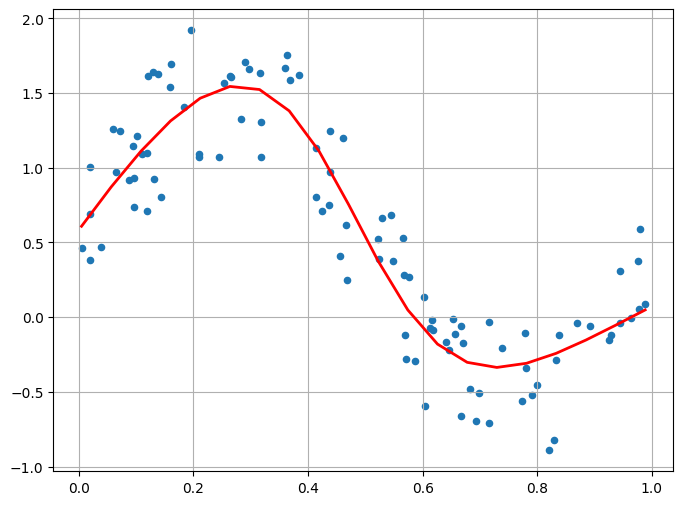

In [80]:
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000

class TwoLayerNet(Model) :
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x) :
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        
        return y
    
model = TwoLayerNet(30, 1)

for i in range(iters) :
    y_pred = model.forward(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    
    loss.backward()
    
    for p in model.params() :
        p.data -= lr * p.grad.data
        
    if (i % 2000 == 0) :
        print(loss)
        
y_pred_plot = model.forward(x_test).data
y_pred_plot = y_pred_plot[:interval]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=20)
plt.plot(x_test, y_pred_plot, color='red', linewidth=2)

plt.grid(True)
plt.show()

### 옵티마이저 (SGD)

variable(0.6358745581053526)
variable(0.22992391895570752)
variable(0.10770450509410441)
variable(0.08086850114657239)
variable(0.0796281304624716)


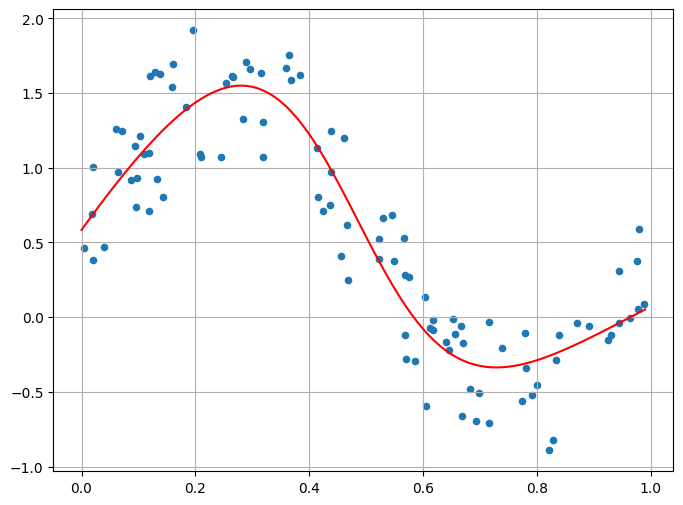

In [81]:
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F
from dezero import optimizers

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000

class TwoLayerNet(Model) :
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x) :
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        
        return y
    
model = TwoLayerNet(30, 1)
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

for i in range(iters) :
    y_pred = model.forward(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    
    loss.backward()
    
    # for p in model.params() :
    #     p.data -= lr * p.grad.data
    
    optimizer.update()
    if (i % 2000 == 0) :
        print(loss)
        
y_pred_plot = model.forward(x_test).data
y_pred_plot = y_pred_plot[:interval]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=20)
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = model(t)
plt.plot(t, y_pred.data, color='r')

plt.grid(True)
plt.show()

### 옵티마이저 (Adam)

variable(0.6358745581053526)
variable(0.07358050890324333)
variable(0.07353033415825538)
variable(0.07349631008276737)
variable(0.07358440721628857)


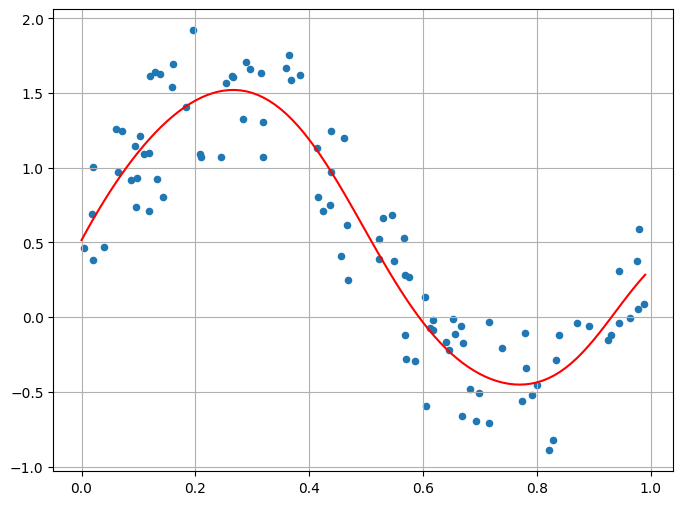

In [82]:
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F
from dezero import optimizers

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000

class TwoLayerNet(Model) :
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x) :
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        
        return y
    
model = TwoLayerNet(30, 1)
optimizer = optimizers.Adam(lr)
optimizer.setup(model)

for i in range(iters) :
    y_pred = model.forward(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    
    loss.backward()
    
    # for p in model.params() :
    #     p.data -= lr * p.grad.data
    
    optimizer.update()
    if (i % 2000 == 0) :
        print(loss)
        
y_pred_plot = model.forward(x_test).data
y_pred_plot = y_pred_plot[:interval]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=20)
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = model(t)
plt.plot(t, y_pred.data, color='r')

plt.grid(True)
plt.show()

## 4. Q-러닝과 신경망

### 신경망의 전처리 - 원-핫 벡터 (인코딩?)

In [83]:
import numpy as np

def one_hot(state) :
    HEIGHT, WIDTH = 3, 4
    
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    
    y, x = state
    
    idx = WIDTH * y + x
    vec[idx] = 1.0
    
    return vec[np.newaxis, :]       # np 배열 확장

state = (2, 0)
x = one_hot(state)

print(x, x.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]] (1, 12)


### Q함수를 표현하는 신경망

In [ ]:
from dezero import Model
import dezero.layers as L
import dezero.functions as F

class QNet(Model) :
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)     # 중간층 크기
        self.l2 = L.Linear(4)       # 행동 크기 (출력층)
        
    def forward(self, x) :
        x = F.relu(self.l1(x))
        x = self.l2(x)
        
        return x
    

qnet = QNet()
state = (2, 0)
state = one_hot(state)
qs = qnet(state)
# qs = qnet.forward(state)
print(qs.shape)

(1, 4)


### Q-러닝 수행하는 에이전트

In [92]:
class QLearningAgent :
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4
        
        self.qnet = QNet()
        self.optimizer = optimizers.SGD(self.lr)
        self.optimizer.setup(self.qnet)
        
    def get_action(self, state_vec) :       # state_vec : 원-핫 벡터로 변환된 상태
        if (np.random.rand() < self.epsilon) :
            return np.random.choice(self.action_size)
        else : 
            qs = self.qnet(state_vec)       # qnet.forward
            return qs.data.argmax()
    
    def update(self, state, action, reward, next_state, done) :
        if (done) :
            next_q = np.zeros(1)        # [0.]
        else : 
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain()            # next_q를 역전파 대상에서 제외
            
        target = reward + self.gamma * next_q
        
        qs = self.qnet(state)           # 현재 상태에서의 Q함수값 계산
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)      # target과 q의 오차 계산
        
        self.qnet.cleargrads()
        
        loss.backward()
        
        self.optimizer.update()
        
        return loss.data

### Q-러닝 에이전트 실행

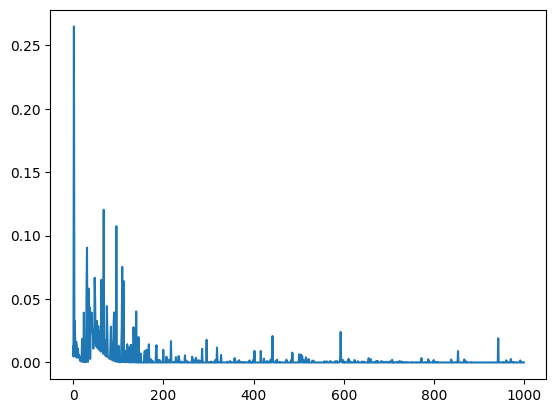

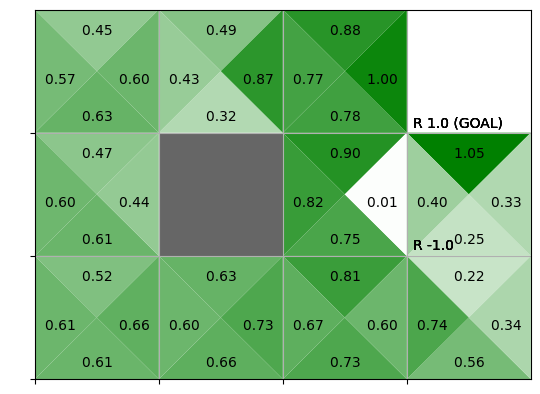

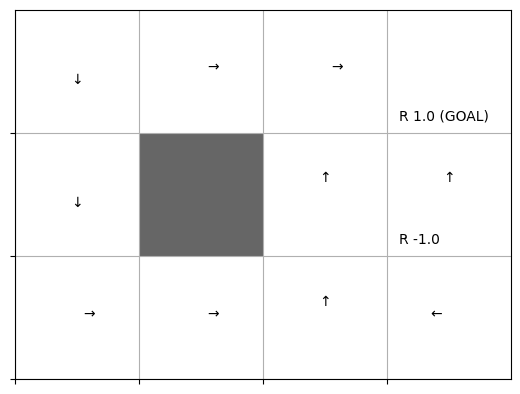

In [93]:
from chap5 import GridWorld

env = GridWorld()
agent = QLearningAgent()

episodes = 1000
loss_history = []

for episode in range(episodes) :
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False
    
    while not done :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)
        
        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        
        cnt += 1
        state = next_state
        
    average_loss = total_loss / cnt
    loss_history.append(average_loss)
    
plt.plot(range(len(loss_history)), loss_history)
plt.show()

Q = {}
for state in env.states() :
    for action in env.action_space :
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)

env.render_q(Q)